# 模型保存与加载

模型训练后，训练好的模型参数保存在内存中，通常需要使用模型保存（save）功能将其持久化保存到磁盘文件中，并在后续需要训练调优或推理部署时，再加载（load）到内存中运行。

在模型训练过程中，通常会在如下场景中用到模型的保存与加载功能：
- 训练调优场景
  - 模型训练过程中定期保存模型，以便后续对不同时期的模型恢复训练或进行研究
  - 模型训练完毕，需要保存模型方便进行评估测试
  - 载入预训练模型，并对模型进行微调（fine-tune）
- 推理部署场景
  - 模型训练完毕，在云、边、端不同的硬件环境中部署使用，飞桨提供了服务器端部署的 Paddle Inference、移动端/IoT端部署的 Paddle Lite、服务化部署的 Paddle Serving 等，以实现模型的快速部署上线
  
  
针对以上场景，飞桨框架推荐使用的模型保存与加载基础 API 主要包括：
- paddle.save
- paddle.load
- paddle.jit.save
- paddle.jit.load

模型保存与加载的高层API主要包括：
- paddle.Model.save
- paddle.Modelload

## 用于训练调优场景

### 保存和加载模型的机制

动态图模式下，模型结构指的是 Python 前端组网代码；模型参数主要指网络层 Layer.state_dict() 和优化器 Optimizer.state_dict()中存放的参数字典。state_dict()中存放了模型参数信息，包括所有可学习的和不可学习的参数（parameters 和 buffers），从网络层（Layer）和优化器（Optimizer）中获取，以字典形式存储，key 为参数名，value 为对应参数数据（Tensor）。
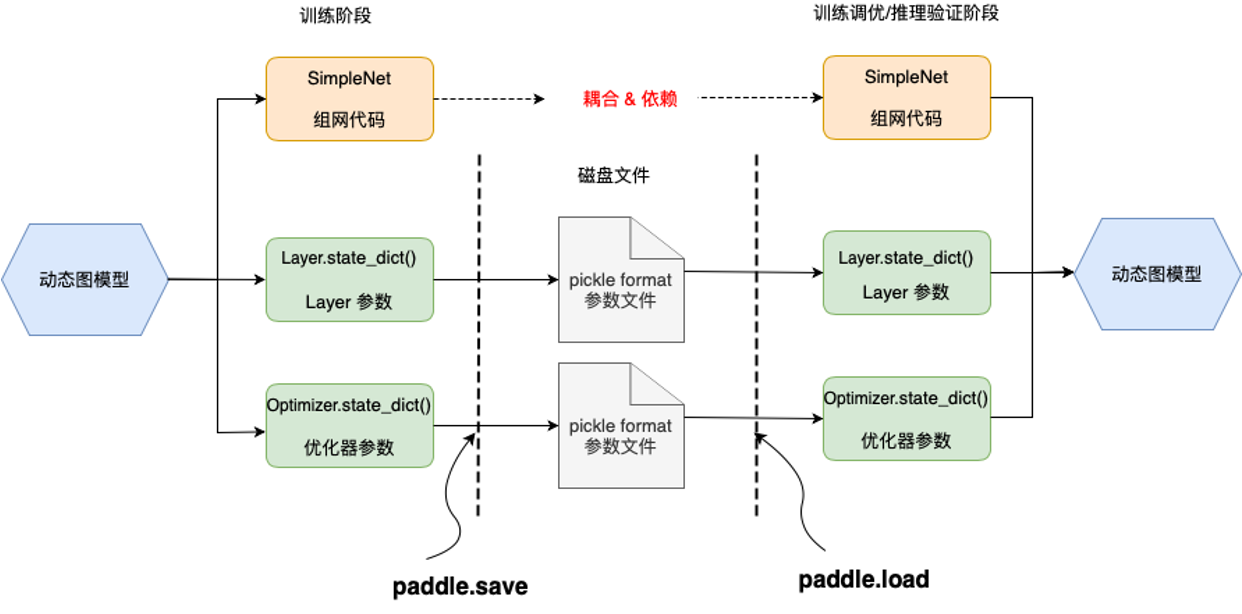

- paddle.save() 实际是通过 Python pickle 模块来实现的，传入要保存的数据对象后，会在指定路径下生成一个 pickle 格式的磁盘文件
- paddle.load() 加载时还需要之前的模型组网代码，并使用传入保存的文件路径，即可重新将之前保存的数据从磁盘文件中载入

另外，paddle.save还支持直接保存 Tensor 数据，或者含 Tensor 的 list/dict 嵌套结构。所以动态图模式下，可支持保存和加载的内容包括：
- 网络层参数 Layer.state_dict()
- 优化器参数 Optimizer.state_dict()
- Tensor数据（如创建的 Tensor 数据、网络层的 weight 数据等）
- 含 Tensor 的 list/dict 嵌套结构对象 （如保存 state_dict() 的嵌套结构对象：obj = {'model': layer.state_dict(), 'opt': adam.state_dict(), 'epoch': 100}）

### 使用基础API

In [1]:
"""使用基础API保存和加载模型

如果要在训练过程中保存模型参数，通常叫保存检查点（checkpoint），需在训练过程中自行设置保存检查点的代码，
如设置定时每几个 epoch 保存一个检查点，设置保存精度最高的检查点等
"""

import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as opt

BATCH_SIZE = 16
BATCH_NUM = 4
EPOCH_NUM = 4

IMAGE_SIZE = 784
CLASS_NUM = 10

final_checkpoint = dict()

In [2]:
# 定义一个随机数据集
class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([IMAGE_SIZE]).astype('float32')
        label = np.random.randint(0, CLASS_NUM - 1, (1, )).astype('int64')
        return image, label

    def __len__(self):
        return self.num_samples

class LinearNet(nn.Layer):
    def __init__(self):
        super().__init__()
        self._linear = nn.Linear(IMAGE_SIZE, CLASS_NUM)

    def forward(self, x):
        return self._linear(x)

def train(layer, loader, loss_fn, opt):
    for epoch_id in range(EPOCH_NUM):
        for batch_id, (image, label) in enumerate(loader()):
            out = layer(image)
            loss = loss_fn(out, label)
            loss.backward()
            opt.step()
            opt.clear_grad()
            print("Epoch {} batch {}: loss = {}".format(
                epoch_id, batch_id, np.mean(loss.numpy())))
        # 最后一个epoch保存检查点checkpoint
        if epoch_id == EPOCH_NUM - 1:
            final_checkpoint["epoch"] = epoch_id
            final_checkpoint["loss"] = loss

In [4]:
# 创建网络、loss和优化器
layer = LinearNet()
loss_fn = nn.CrossEntropyLoss()
adam = opt.Adam(learning_rate=0.001, parameters=layer.parameters())

# 创建用于载入数据的DataLoader
dataset = RandomDataset(BATCH_NUM * BATCH_SIZE)
loader = paddle.io.DataLoader(dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=2)

# 开始训练
train(layer, loader, loss_fn, adam)

Epoch 0 batch 0: loss = 2.6759161949157715
Epoch 0 batch 1: loss = 2.7608754634857178
Epoch 0 batch 2: loss = 2.656525135040283
Epoch 0 batch 3: loss = 2.553971529006958
Epoch 1 batch 0: loss = 2.5679678916931152
Epoch 1 batch 1: loss = 2.4771318435668945
Epoch 1 batch 2: loss = 2.436610221862793
Epoch 1 batch 3: loss = 2.3741555213928223
Epoch 2 batch 0: loss = 2.614204168319702
Epoch 2 batch 1: loss = 2.528054714202881
Epoch 2 batch 2: loss = 2.6646695137023926
Epoch 2 batch 3: loss = 2.2449584007263184
Epoch 3 batch 0: loss = 2.5424227714538574
Epoch 3 batch 1: loss = 1.9787323474884033
Epoch 3 batch 2: loss = 2.336984872817993
Epoch 3 batch 3: loss = 2.404496669769287


In [5]:
"""保存动态图模型

参数保存时，先获取目标对象（Layer 或者 Optimzier）的 state_dict，然后将 state_dict 保存至磁盘，同时也可以保存模型训练 checkpoint 的信息
paddle.save 的文件名称是自定义的，以输入参数 path 直接作为存储结果的文件名，推荐的标准文件后缀：
- 模型参数 Layer.state_dict() ，推荐使用后缀 .pdparams
- 优化器参数 Optimizer.state_dict()，推荐使用后缀 .pdopt
"""

# 保存模型参数
paddle.save(layer.state_dict(), '../models/linear_net.pdparams')

# 保存优化器参数
paddle.save(adam.state_dict(), '../models/adam.pdopt')

# 保存检查点信息
paddle.save(final_checkpoint, '../models/final_checkpoint.pkl')

In [6]:
"""加载动态图模型

参数载入时，先从磁盘载入保存的 state_dict，然后通过 set_state_dict()方法将 state_dict 配置到目标对象中
加载以后就可以继续对动态图模型进行训练调优（fine-tune），或者验证预测效果（predict）
"""

# 加载模型参数、优化器参数和最后一个检查点信息
layer_state_dict = paddle.load('../models/linear_net.pdparams')
opt_state_dict = paddle.load('../models/adam.pdopt')
final_checkpoint_dict = paddle.load('../models/final_checkpoint.pkl')

# 将加载后的参数和模型关联起来
layer.set_state_dict(layer_state_dict)
adam.set_state_dict(opt_state_dict)

# 打印加载后的最后一个检查点信息
print('Loaded Final Checkpoint. Epoch: {}, Loss: {}'.format(final_checkpoint_dict['epoch'], final_checkpoint_dict['loss'].numpy()))

Loaded Final Checkpoint. Epoch: 3, Loss: [2.4044967]
